In [1]:
import pandas as pd
import os
import numpy as np
import plotly.express as px
import re
from geopy.geocoders import Nominatim
import folium
import geopy
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.patches as mpatches
from scipy import stats


In [2]:
df_import = pd.read_csv('data/eda.csv')

In [31]:
#List of houses that meet clients condition
conditions_df = df_import.query('bathrooms >=4 and waterfront == 0 and yr_built < 1975').copy()
conditions_df.loc[:,'sqft_outside'] = conditions_df['sqft_lot'] - conditions_df['sqft_living'] - conditions_df['sqft_basement'].fillna(0)

space_for_court_and_pool = 4800 + 800 #recommended tennis court 30x15m - about 4800sqft, residential pool 800sqft, olympic pool 13.123sqft
df_outside = conditions_df[conditions_df['sqft_outside'] > space_for_court_and_pool + 400].copy() #buffer space outside
df_outside['sqft_outside_left_after_cond'] = df_outside['sqft_outside'] - (space_for_court_and_pool + 400) #+ buffer

df_possible_houses  = df_outside.sort_values(by= 'sqft_outside_left_after_cond', ascending=False)
df_possible_houses

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date,price,sqft_outside,sqft_outside_left_after_cond
15152,3304700130,4.0,4.00,3860.0,67953.0,2.0,0.0,2.0,4,12,...,0.0,98177,47.7469,-122.378,4410.0,128066.0,2015-01-28,1760000.0,64093.0,58093.0
3314,2821049048,4.0,4.25,2360.0,57514.0,2.0,0.0,0.0,4,8,...,NaN,98003,47.2843,-122.294,2037.0,35733.0,2014-06-03,590000.0,55154.0,49154.0
14542,2303900035,5.0,6.25,8670.0,64033.0,2.0,0.0,4.0,3,13,...,NaN,98177,47.7295,-122.372,4140.0,81021.0,2014-06-11,2890000.0,52813.0,46813.0
3018,3377900195,4.0,5.50,6930.0,45100.0,1.0,0.0,0.0,4,11,...,19910.0,98006,47.5547,-122.144,2560.0,37766.0,2014-09-29,2530000.0,38170.0,32170.0
5961,5249800010,4.0,4.25,6410.0,43838.0,2.5,0.0,2.0,4,12,...,0.0,98144,47.5703,-122.280,2270.0,6630.0,2014-12-03,2730000.0,36628.0,30628.0
19445,722059020,6.0,4.50,4520.0,40164.0,2.0,0.0,0.0,3,9,...,20080.0,98031,47.4070,-122.216,2870.0,13068.0,2015-03-18,550000.0,34704.0,28704.0
4020,9175600025,7.0,6.75,7480.0,41664.0,2.0,0.0,2.0,3,11,...,NaN,98166,47.4643,-122.368,2810.0,33190.0,2014-10-07,800000.0,31784.0,25784.0
8507,3425059141,7.0,4.00,3150.0,34830.0,1.0,0.0,0.0,3,9,...,20050.0,98007,47.6029,-122.147,2390.0,12054.0,2014-05-28,999000.0,31680.0,25680.0
14172,1333300145,3.0,4.00,4200.0,30120.0,2.0,0.0,2.0,4,11,...,0.0,98112,47.6379,-122.311,2760.0,12200.0,2015-03-04,2230000.0,25320.0,19320.0
17665,3585901085,6.0,4.50,3810.0,28176.0,1.0,0.0,4.0,5,10,...,0.0,98177,47.7612,-122.381,3810.0,26400.0,2014-06-04,2010000.0,24366.0,18366.0


In [ ]:
#Houses in the top25% price wise
average_price = df_import['price'].mean()
q3_price = df_import['price'].quantile(0.75)

more_than_mean = df_possible_houses['price'] > average_price
more_than_q3 = df_possible_houses['price'] > q3_price
more_than_q3.sum()
(~more_than_q3).sum() #calculate how many False

print( f"not more than mean: {(~more_than_mean).sum()}. not in q3: {(~more_than_q3).sum()}")

not more than mean: 1. not in q3: 4


In [34]:
#get seattle zipcodes
zipcodes_raw = """<list><div id="zipcodes" class="py-3 anchor-scroll"><div class="container"><h2>Seattle, WA has 60 ZIP Codes</h2><hr><div class="table-responsive"><table border="0" cellspacing="0" cellpadding="0" width="100%" class="table table-striped table-hover table-bordered small border rounded-3 overflow-hidden sortableTbl" id="tblZIP"><thead><tr><th nowrap="" class="header headerSortDown">ZIP Code</th><th class="header">Type</th><th axis="num" class="header"><span class="d-none d-md-block">Population</span><span class="d-block d-md-none d-lg-none">Pop</span></th><th class="header"><span class="d-none d-md-block">% of Population</span><span class="d-block d-md-none d-lg-none">% of Pop</span></th><th class="header">Alias Names</th></tr></thead><tbody><tr><td><a href="/zip-code/98101/zip-code-98101.asp" title="ZIP Code 98101">98101</a></td><td>Standard</td><td>16,237</td><td>1.60%</td><td>Times Square</td></tr><tr><td><a href="/zip-code/98102/zip-code-98102.asp" title="ZIP Code 98102">98102</a></td><td>Standard</td><td>25,066</td><td>2.46%</td><td>Broadway, Capitol Hill</td></tr><tr><td><a href="/zip-code/98103/zip-code-98103.asp" title="ZIP Code 98103">98103</a></td><td>Standard</td><td>53,056</td><td>5.21%</td><td>Greenwood, Wallingford</td></tr><tr><td><a href="/zip-code/98104/zip-code-98104.asp" title="ZIP Code 98104">98104</a></td><td>Standard</td><td>16,157</td><td>1.59%</td><td>International, Pioneer Square</td></tr><tr><td><a href="/zip-code/98105/zip-code-98105.asp" title="ZIP Code 98105">98105</a></td><td>Standard</td><td>49,151</td><td>4.83%</td><td>University</td></tr><tr><td><a href="/zip-code/98106/zip-code-98106.asp" title="ZIP Code 98106">98106</a></td><td>Standard</td><td>26,295</td><td>2.58%</td><td>White Center</td></tr><tr><td><a href="/zip-code/98107/zip-code-98107.asp" title="ZIP Code 98107">98107</a></td><td>Standard</td><td>28,557</td><td>2.81%</td><td>Ballard</td></tr><tr><td><a href="/zip-code/98108/zip-code-98108.asp" title="ZIP Code 98108">98108</a></td><td>Standard</td><td>25,009</td><td>2.46%</td><td>Tukwila</td></tr><tr><td><a href="/zip-code/98109/zip-code-98109.asp" title="ZIP Code 98109">98109</a></td><td>Standard</td><td>34,551</td><td>3.40%</td><td>Queen Anne</td></tr><tr><td><a href="/zip-code/98110/zip-code-98110.asp" title="ZIP Code 98110">98110</a></td><td>Standard</td><td>24,825</td><td>2.44%</td><td>Bainbridge Is, Seattle</td></tr><tr><td><a href="/zip-code/98111/zip-code-98111.asp" title="ZIP Code 98111">98111</a> <i class="fa-solid fa-box" title="PO BOX ZIP Code"></i></td><td>P.O. Box</td><td>0</td><td>0.00%</td><td></td></tr><tr><td><a href="/zip-code/98112/zip-code-98112.asp" title="ZIP Code 98112">98112</a></td><td>Standard</td><td>23,152</td><td>2.28%</td><td>Madison Park</td></tr><tr><td><a href="/zip-code/98113/zip-code-98113.asp" title="ZIP Code 98113">98113</a> <i class="fa-solid fa-box" title="PO BOX ZIP Code"></i></td><td>P.O. Box</td><td>0</td><td>0.00%</td><td></td></tr><tr><td><a href="/zip-code/98114/zip-code-98114.asp" title="ZIP Code 98114">98114</a> <i class="fa-solid fa-box" title="PO BOX ZIP Code"></i></td><td>P.O. Box</td><td>0</td><td>0.00%</td><td></td></tr><tr><td><a href="/zip-code/98115/zip-code-98115.asp" title="ZIP Code 98115">98115</a></td><td>Standard</td><td>54,322</td><td>5.34%</td><td>Seattle Naval Support Activi, Wedgwood</td></tr><tr><td><a href="/zip-code/98116/zip-code-98116.asp" title="ZIP Code 98116">98116</a></td><td>Standard</td><td>27,691</td><td>2.72%</td><td>West Seattle</td></tr><tr><td><a href="/zip-code/98117/zip-code-98117.asp" title="ZIP Code 98117">98117</a></td><td>Standard</td><td>35,608</td><td>3.50%</td><td>Crown Hill</td></tr><tr><td><a href="/zip-code/98118/zip-code-98118.asp" title="ZIP Code 98118">98118</a></td><td>Standard</td><td>47,504</td><td>4.67%</td><td>Columbia</td></tr><tr><td><a href="/zip-code/98119/zip-code-98119.asp" title="ZIP Code 98119">98119</a></td><td>Standard</td><td>26,238</td><td>2.58%</td><td>Interbay</td></tr><tr><td><a href="/zip-code/98121/zip-code-98121.asp" title="ZIP Code 98121">98121</a></td><td>Standard</td><td>21,411</td><td>2.10%</td><td></td></tr><tr><td><a href="/zip-code/98122/zip-code-98122.asp" title="ZIP Code 98122">98122</a></td><td>Standard</td><td>41,646</td><td>4.09%</td><td>East Union</td></tr><tr><td><a href="/zip-code/98124/zip-code-98124.asp" title="ZIP Code 98124">98124</a> <i class="fa-solid fa-box" title="PO BOX ZIP Code"></i></td><td>P.O. Box</td><td>0</td><td>0.00%</td><td></td></tr><tr><td><a href="/zip-code/98125/zip-code-98125.asp" title="ZIP Code 98125">98125</a></td><td>Standard</td><td>42,965</td><td>4.22%</td><td>Lake City, Northgate</td></tr><tr><td><a href="/zip-code/98126/zip-code-98126.asp" title="ZIP Code 98126">98126</a></td><td>Standard</td><td>23,727</td><td>2.33%</td><td>Westwood Village</td></tr><tr><td><a href="/zip-code/98127/zip-code-98127.asp" title="ZIP Code 98127">98127</a> <i class="fa-solid fa-box" title="PO BOX ZIP Code"></i></td><td>P.O. Box</td><td>0</td><td>0.00%</td><td></td></tr><tr><td><a href="/zip-code/98129/zip-code-98129.asp" title="ZIP Code 98129">98129</a> <i class="fa-solid fa-building" title="Unique/Business ZIP Code"></i></td><td>Unique</td><td>0</td><td>0.00%</td><td>Reg Lib Handicapped</td></tr><tr><td><a href="/zip-code/98131/zip-code-98131.asp" title="ZIP Code 98131">98131</a></td><td>Standard</td><td>0</td><td>0.00%</td><td></td></tr><tr><td><a href="/zip-code/98133/zip-code-98133.asp" title="ZIP Code 98133">98133</a></td><td>Standard</td><td>50,720</td><td>4.99%</td><td>Bitter Lake, Richmond Highlands, Shoreline</td></tr><tr><td><a href="/zip-code/98134/zip-code-98134.asp" title="ZIP Code 98134">98134</a></td><td>Standard</td><td>1,216</td><td>0.12%</td><td></td></tr><tr><td><a href="/zip-code/98136/zip-code-98136.asp" title="ZIP Code 98136">98136</a></td><td>Standard</td><td>16,424</td><td>1.61%</td><td>Westwood</td></tr><tr><td><a href="/zip-code/98138/zip-code-98138.asp" title="ZIP Code 98138">98138</a> <i class="fa-solid fa-box" title="PO BOX ZIP Code"></i></td><td>P.O. Box</td><td>0</td><td>0.00%</td><td>Tukwila</td></tr><tr><td><a href="/zip-code/98139/zip-code-98139.asp" title="ZIP Code 98139">98139</a> <i class="fa-solid fa-box" title="PO BOX ZIP Code"></i></td><td>P.O. Box</td><td>0</td><td>0.00%</td><td></td></tr><tr><td><a href="/zip-code/98141/zip-code-98141.asp" title="ZIP Code 98141">98141</a> <i class="fa-solid fa-box" title="PO BOX ZIP Code"></i></td><td>P.O. Box</td><td>0</td><td>0.00%</td><td></td></tr><tr><td><a href="/zip-code/98144/zip-code-98144.asp" title="ZIP Code 98144">98144</a></td><td>Standard</td><td>32,178</td><td>3.16%</td><td>Beacon Hill</td></tr><tr><td><a href="/zip-code/98145/zip-code-98145.asp" title="ZIP Code 98145">98145</a> <i class="fa-solid fa-box" title="PO BOX ZIP Code"></i></td><td>P.O. Box</td><td>0</td><td>0.00%</td><td></td></tr><tr><td><a href="/zip-code/98146/zip-code-98146.asp" title="ZIP Code 98146">98146</a></td><td>Standard</td><td>28,845</td><td>2.84%</td><td>Burien, Shorewood, White Center</td></tr><tr><td><a href="/zip-code/98148/zip-code-98148.asp" title="ZIP Code 98148">98148</a></td><td>Standard</td><td>11,092</td><td>1.09%</td><td>Burien, Des Moines, Normandy Park, Seatac</td></tr><tr><td><a href="/zip-code/98154/zip-code-98154.asp" title="ZIP Code 98154">98154</a></td><td>Standard</td><td>0</td><td>0.00%</td><td></td></tr><tr><td><a href="/zip-code/98155/zip-code-98155.asp" title="ZIP Code 98155">98155</a></td><td>Standard</td><td>35,948</td><td>3.53%</td><td>Forest Park, Lake Forest Park, Lk Forest Park, Lk Forest Pk, North City, Shoreline</td></tr><tr><td><a href="/zip-code/98158/zip-code-98158.asp" title="ZIP Code 98158">98158</a></td><td>Standard</td><td>0</td><td>0.00%</td><td>Seatac, Seatac Airport</td></tr><tr><td><a href="/zip-code/98160/zip-code-98160.asp" title="ZIP Code 98160">98160</a> <i class="fa-solid fa-box" title="PO BOX ZIP Code"></i></td><td>P.O. Box</td><td>0</td><td>0.00%</td><td>Richmond Beach</td></tr><tr><td><a href="/zip-code/98161/zip-code-98161.asp" title="ZIP Code 98161">98161</a></td><td>Standard</td><td>0</td><td>0.00%</td><td></td></tr><tr><td><a href="/zip-code/98164/zip-code-98164.asp" title="ZIP Code 98164">98164</a></td><td>Standard</td><td>176</td><td>0.02%</td><td></td></tr><tr><td><a href="/zip-code/98165/zip-code-98165.asp" title="ZIP Code 98165">98165</a> <i class="fa-solid fa-box" title="PO BOX ZIP Code"></i></td><td>P.O. Box</td><td>0</td><td>0.00%</td><td></td></tr><tr><td><a href="/zip-code/98166/zip-code-98166.asp" title="ZIP Code 98166">98166</a></td><td>Standard</td><td>22,152</td><td>2.18%</td><td>Burien, Normandy Park</td></tr><tr><td><a href="/zip-code/98168/zip-code-98168.asp" title="ZIP Code 98168">98168</a></td><td>Standard</td><td>36,389</td><td>3.58%</td><td>Burien, Seatac, Tukwila</td></tr><tr><td><a href="/zip-code/98170/zip-code-98170.asp" title="ZIP Code 98170">98170</a> <i class="fa-solid fa-building" title="Unique/Business ZIP Code"></i></td><td>Unique</td><td>0</td><td>0.00%</td><td>Amazon.com</td></tr><tr><td><a href="/zip-code/98174/zip-code-98174.asp" title="ZIP Code 98174">98174</a></td><td>Standard</td><td>0</td><td>0.00%</td><td></td></tr><tr><td><a href="/zip-code/98175/zip-code-98175.asp" title="ZIP Code 98175">98175</a> <i class="fa-solid fa-box" title="PO BOX ZIP Code"></i></td><td>P.O. Box</td><td>0</td><td>0.00%</td><td></td></tr><tr><td><a href="/zip-code/98177/zip-code-98177.asp" title="ZIP Code 98177">98177</a></td><td>Standard</td><td>20,160</td><td>1.98%</td><td>Bitter Lake, Richmond Beach, Shoreline, The Highlands</td></tr><tr><td><a href="/zip-code/98178/zip-code-98178.asp" title="ZIP Code 98178">98178</a></td><td>Standard</td><td>26,122</td><td>2.57%</td><td>Bryn Mawr, Skyway, Tukwila</td></tr><tr><td><a href="/zip-code/98181/zip-code-98181.asp" title="ZIP Code 98181">98181</a> <i class="fa-solid fa-building" title="Unique/Business ZIP Code"></i></td><td>Unique</td><td>0</td><td>0.00%</td><td>Macys</td></tr><tr><td><a href="/zip-code/98185/zip-code-98185.asp" title="ZIP Code 98185">98185</a> <i class="fa-solid fa-building" title="Unique/Business ZIP Code"></i></td><td>Unique</td><td>0</td><td>0.00%</td><td>Safeco Plaza</td></tr><tr><td><a href="/zip-code/98188/zip-code-98188.asp" title="ZIP Code 98188">98188</a></td><td>Standard</td><td>27,851</td><td>2.74%</td><td>Duwamish, Mcmicken Heights, Riverton, Seatac, Tukwila</td></tr><tr><td><a href="/zip-code/98190/zip-code-98190.asp" title="ZIP Code 98190">98190</a> <i class="fa-solid fa-building" title="Unique/Business ZIP Code"></i></td><td>Unique</td><td>0</td><td>0.00%</td><td>Capital One</td></tr><tr><td><a href="/zip-code/98191/zip-code-98191.asp" title="ZIP Code 98191">98191</a> <i class="fa-solid fa-building" title="Unique/Business ZIP Code"></i></td><td>Unique</td><td>0</td><td>0.00%</td><td>Qwest</td></tr><tr><td><a href="/zip-code/98194/zip-code-98194.asp" title="ZIP Code 98194">98194</a> <i class="fa-solid fa-box" title="PO BOX ZIP Code"></i></td><td>P.O. Box</td><td>0</td><td>0.00%</td><td></td></tr><tr><td><a href="/zip-code/98195/zip-code-98195.asp" title="ZIP Code 98195">98195</a> <i class="fa-solid fa-building" title="Unique/Business ZIP Code"></i></td><td>Unique</td><td>3,710</td><td>0.36%</td><td>Univ Of Washington</td></tr><tr><td><a href="/zip-code/98198/zip-code-98198.asp" title="ZIP Code 98198">98198</a></td><td>Standard</td><td>38,727</td><td>3.81%</td><td>Des Moines, Normandy Park, Redondo Beach, Seatac</td></tr><tr><td><a href="/zip-code/98199/zip-code-98199.asp" title="ZIP Code 98199">98199</a></td><td>Standard</td><td>22,549</td><td>2.22%</td><td>Fort Lawton, Magnolia</td></tr></tbody></table></div><ins class="adsbygoogle container" style="display:block" data-ad-client="ca-pub-6449469715038723" data-ad-slot="9841517722" data-ad-format="auto" data-full-width-responsive="true" data-adsbygoogle-status="done"><iframe id="aswift_1" style="height: 1px !important; max-height: 1px !important; max-width: 1px !important; width: 1px !important;"><iframe id="google_ads_frame1"></iframe></iframe></ins></div></div></list>"""
pattern = r'zip-code/(\d{5})/'
seattle_zipcodes = re.findall(pattern, zipcodes_raw)
zips = pd.DataFrame(seattle_zipcodes, columns= ['zipcode'])

In [35]:
#amount of selected houses in seattle
houses_in_seattle = df_possible_houses[df_possible_houses['zipcode'].astype(str).isin(seattle_zipcodes)]
houses_in_seattle.describe()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,price,sqft_outside,sqft_outside_left_after_cond
count,1.500000e+01,15.000000,15.000000,15.000000,15.000000,15.000000,15.0,15.000000,15.000000,15.000000,...,15.000000,15.000000,12.000000,15.000000,15.000000,15.000000,15.000000,1.500000e+01,15.000000,15.000000
mean,3.934194e+09,4.800000,4.883333,5501.666667,29180.666667,2.000000,0.0,1.866667,3.933333,10.800000,...,1094.666667,1940.200000,4999.166667,47.626013,-122.325933,3244.000000,25956.466667,2.480800e+06,22584.333333,16584.333333
std,2.923514e+09,1.082326,1.187234,2554.666365,17964.521009,0.597614,0.0,1.552264,0.798809,1.740279,...,1056.658254,20.014994,9043.969823,0.107394,0.048890,1019.529303,33938.549901,1.724196e+06,17340.446632,17340.446632
min,2.390002e+08,3.000000,4.000000,1400.000000,8580.000000,1.000000,0.0,0.000000,3.000000,7.000000,...,0.000000,1906.000000,0.000000,47.427400,-122.408000,1220.000000,6477.000000,2.650000e+05,6525.000000,525.000000
25%,1.225651e+09,4.000000,4.125000,4030.000000,17124.000000,2.000000,0.0,0.000000,3.000000,10.000000,...,430.000000,1926.500000,0.000000,47.598300,-122.374000,2785.000000,9259.500000,1.645000e+06,9314.000000,3314.000000
50%,3.585900e+09,5.000000,4.500000,4720.000000,24085.000000,2.000000,0.0,2.000000,4.000000,11.000000,...,670.000000,1939.000000,0.000000,47.637900,-122.311000,3750.000000,12040.000000,2.530000e+06,17077.000000,11077.000000
75%,5.348451e+09,5.500000,4.875000,6755.000000,35892.000000,2.500000,0.0,3.000000,4.500000,12.000000,...,1740.000000,1953.500000,4967.500000,47.699850,-122.286000,3950.000000,23200.000000,2.905000e+06,28552.000000,22552.000000
max,9.471200e+09,7.000000,8.000000,12050.000000,67953.000000,3.000000,0.0,4.000000,5.000000,13.000000,...,3480.000000,1971.000000,20100.000000,47.761200,-122.260000,4410.000000,128066.000000,7.700000e+06,64093.000000,58093.000000


## less strict conditions

In [46]:
houses_in_seattle = df_import[df_import['zipcode'].isin(seattle_zipcodes)]

lesser_condition_in_seattle = df_import.query('bathrooms >=3 and waterfront == 0 and yr_built < 1975').copy()
lesser_condition_in_seattle.loc[:,'sqft_outside'] = lesser_condition_in_seattle['sqft_lot'] - lesser_condition_in_seattle['sqft_living'] - lesser_condition_in_seattle['sqft_basement'].fillna(0)


df_lesser_houses = lesser_condition_in_seattle[lesser_condition_in_seattle['sqft_outside'] > space_for_court_and_pool + 400].copy()

df_lesser_houses['sqft_outside_left_after_cond'] = df_lesser_houses['sqft_outside'] - (space_for_court_and_pool + 400)
df_lesser_houses.describe()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,price,sqft_outside,sqft_outside_left_after_cond
count,1.730000e+02,173.000000,173.000000,173.000000,173.000000,173.000000,173.0,173.000000,173.000000,173.000000,...,168.000000,173.000000,139.000000,173.000000,173.000000,173.000000,173.000000,1.730000e+02,173.000000,173.000000
mean,4.419085e+09,4.508671,3.432081,3530.924855,29660.930636,1.531792,0.0,0.913295,3.716763,8.739884,...,728.017857,1955.017341,6618.129496,47.590091,-122.232919,2722.017341,21530.861272,1.174959e+06,25423.028902,19423.028902
std,2.737926e+09,0.974193,0.680456,1275.823291,44692.774665,0.517570,0.0,1.328794,0.759136,1.362485,...,734.422731,16.997768,9444.432419,0.109998,0.096955,785.148664,30098.345454,8.942966e+05,44792.606136,44792.606136
min,1.141007e+08,2.000000,3.000000,1400.000000,8170.000000,1.000000,0.0,0.000000,3.000000,6.000000,...,0.000000,1902.000000,0.000000,47.284300,-122.504000,1220.000000,4950.000000,2.550000e+05,6085.000000,85.000000
25%,2.025059e+09,4.000000,3.000000,2720.000000,11920.000000,1.000000,0.0,0.000000,3.000000,8.000000,...,0.000000,1949.000000,0.000000,47.533800,-122.295000,2120.000000,10230.000000,5.750000e+05,8396.000000,2396.000000
50%,3.627800e+09,4.000000,3.250000,3380.000000,16224.000000,1.500000,0.0,0.000000,4.000000,8.000000,...,600.000000,1960.000000,0.000000,47.591100,-122.229000,2640.000000,13113.000000,8.950000e+05,11800.000000,5800.000000
75%,6.744700e+09,5.000000,3.500000,4020.000000,28300.000000,2.000000,0.0,2.000000,4.000000,10.000000,...,1292.500000,1968.000000,19940.000000,47.652000,-122.173000,3340.000000,20000.000000,1.530000e+06,24366.000000,18366.000000
max,9.808100e+09,8.000000,8.000000,12050.000000,443440.000000,3.000000,0.0,4.000000,5.000000,13.000000,...,3480.000000,1974.000000,20150.000000,47.775700,-122.000000,4480.000000,298182.000000,7.700000e+06,440740.000000,434740.000000


In [7]:
# range in which the houses in their zipcode area were built
range_built_yrs = df_import.groupby('zipcode').agg(range=('yr_built',lambda x:x.max()-x.min()))
print(range_built_yrs.describe())

df_import_range = df_import.merge(range_built_yrs, on = 'zipcode',how='left')

            range
count   70.000000
mean   104.385714
std     13.950526
min     54.000000
25%    101.250000
50%    110.000000
75%    114.000000
max    115.000000


In [8]:
#added addresses
geo = Nominatim(user_agent='phillips')
def get_address(row):
    location = geo.reverse((row['lat'], row['long']))
    return location.address if location else None

df_possible_houses['address'] = df_possible_houses.apply(get_address, axis = 1)

In [9]:
#king county info geodataframe
king_county_map = gpd.read_file("Zipcodes_for_King_County_and_Surrounding_Area___zipcode_area/Zipcodes_for_King_County_and_Surrounding_Area___zipcode_area.shp")
king_county_map=king_county_map.rename(columns=str.lower)
king_county_map['zipcode']= king_county_map['zipcode'].astype(str)
df_import['zipcode']= df_import['zipcode'].astype(str)

df_import_range['zipcode']= df_import_range['zipcode'].astype(str)

map_and_stats = king_county_map.merge(df_import_range, on = 'zipcode')


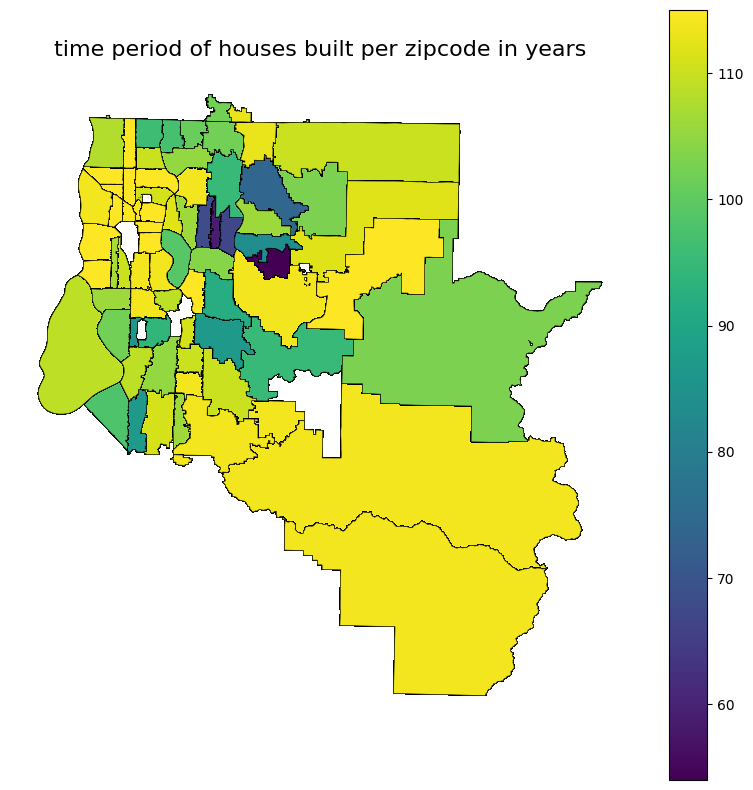

In [10]:
#map of range of years in which houses were built per zipcode
fig, ax = plt.subplots(1, figsize=(10,10))
map_and_stats.plot(column='range', cmap='viridis',linewidth=0.4,ax=ax,legend=True, edgecolor= 'black')

ax.set_axis_off()
plt.title('time period of houses built per zipcode in years',size=16)
plt.show()


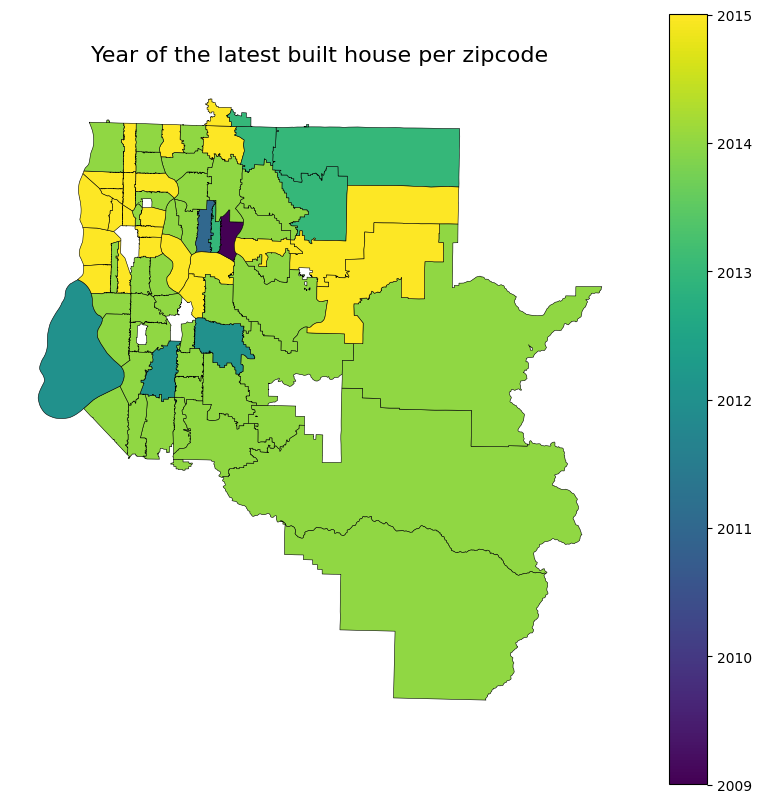

In [11]:
# newest built houses
max_years = df_import.groupby('zipcode', as_index=False).agg(max_year=('yr_built','max'))

max_years['zipcode']= max_years['zipcode'].astype(str)
max_years

map_and_stats_maxy = king_county_map.merge(max_years, on = 'zipcode')

fig, ax = plt.subplots(1, figsize=(10,10))

map_and_stats_maxy.plot(column='max_year', cmap='viridis',linewidth=0.4,ax=ax,legend=True,edgecolor= 'black')

ax.set_axis_off()

plt.title('Year of the latest built house per zipcode', fontsize= 16)
plt.show()

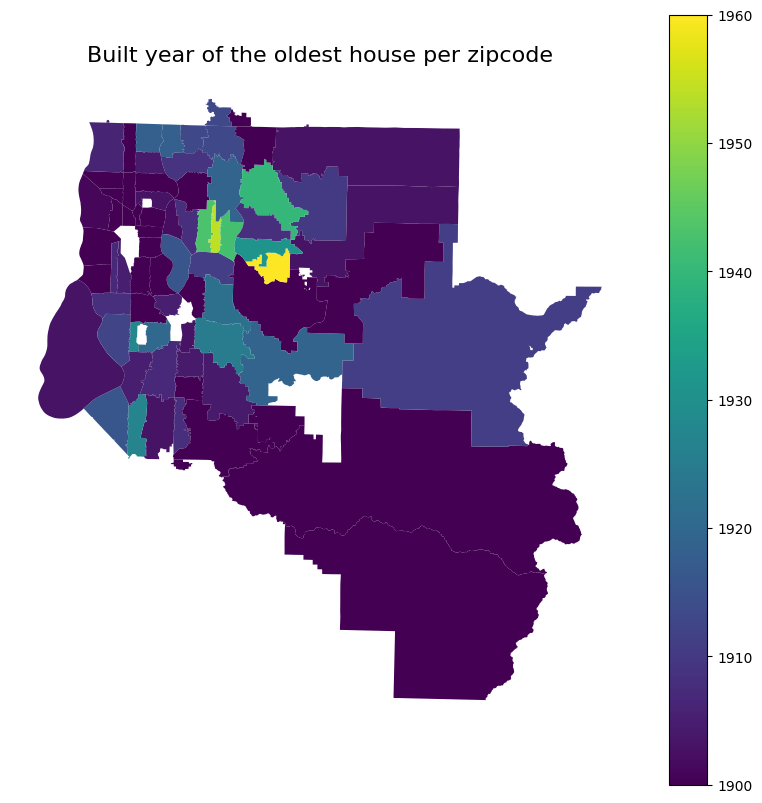

In [12]:
min_years = df_import.groupby('zipcode', as_index=False).agg(min_year=('yr_built','min'))

min_years['zipcode']= min_years['zipcode'].astype(str)


map_and_stats_miny = king_county_map.merge(min_years, on = 'zipcode')

fig, ax = plt.subplots(1, figsize=(10,10))

map_and_stats_miny.plot(column='min_year', cmap='viridis',linewidth=0.4,ax=ax,legend=True)

ax.set_axis_off()
plt.title('Built year of the oldest house per zipcode', fontsize= 16)
plt.show()

In [13]:
#golf courses
golf_course_zips = [98053,98126,98119,98112,98052,98115,98070,98008,98005,98177,98103,98059,98038,98024,98125,98065,98072,98092,98045,98022,98003,98042,98014,98039,98058,98023,98011,98188]


df_import['zipcode'].isin(golf_course_zips).sum()
df_possible_houses['zipcode'].isin(golf_course_zips).sum()

np.int64(11)

In [56]:
# Area of Seattle

seattle = king_county_map.query('preferred_ == "SEATTLE"')
seattle_zips = [str(zipcode) for zipcode in seattle['zipcode']]


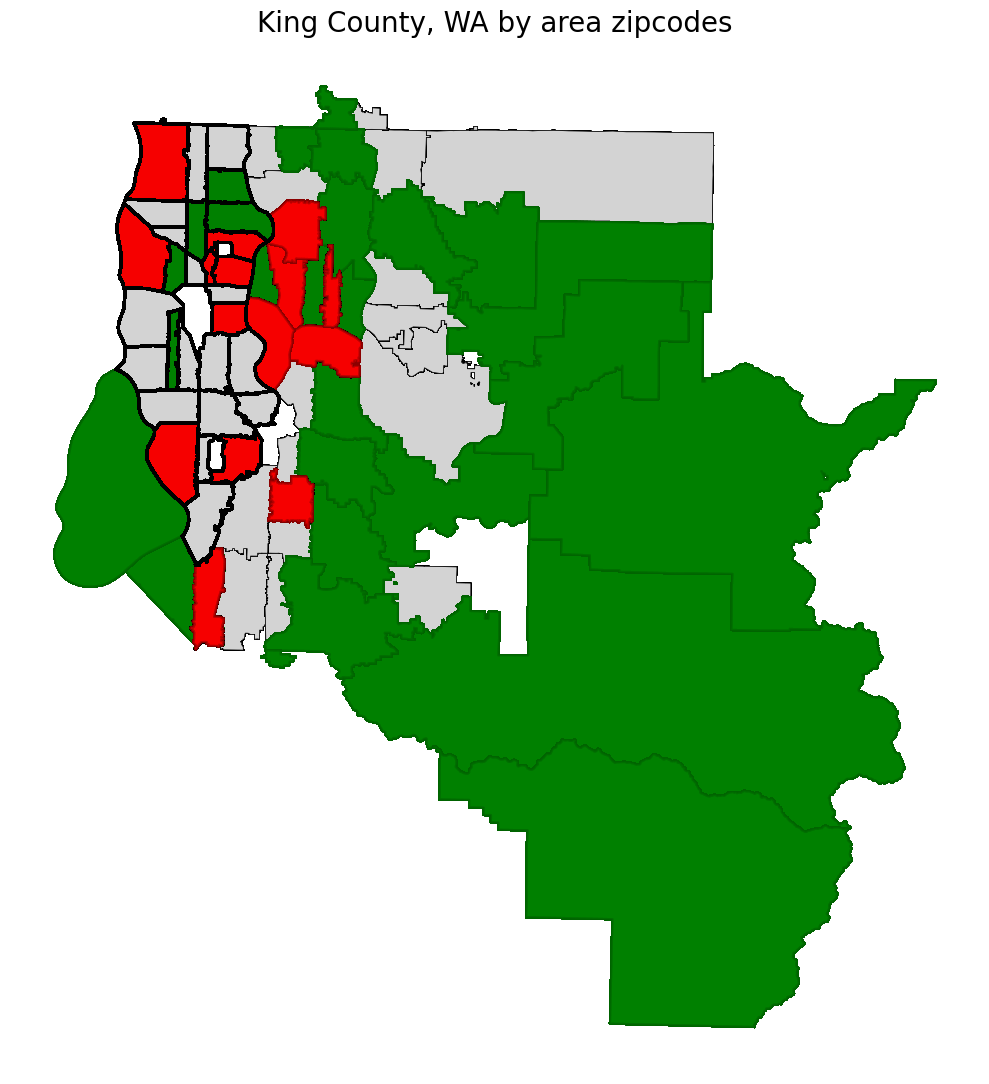

In [57]:
#Map of Zipcodes with golf courses and our 26 houses with marked seattle border

map_and_stats['seattle_highlight'] = map_and_stats['zipcode'].isin(seattle_zips)

target_zipcodes = [str(zipcode) for zipcode in df_possible_houses['zipcode']]
golf_course_zips = [str(zipcode) for zipcode in golf_course_zips]


map_and_stats['houses_highlight'] = map_and_stats['zipcode'].isin(target_zipcodes)
map_and_stats['golf_highlight'] = map_and_stats['zipcode'].isin(golf_course_zips)


fig, ax = plt.subplots(1, figsize=(10, 20))

#all zipcodes 
map_and_stats.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.5)

#golf course zipcodes
golf_highlighted = map_and_stats[map_and_stats['golf_highlight']]
golf_highlighted.plot(ax=ax, color='green', edgecolor='darkgreen', linewidth=1.5, alpha=0.4)

# house zipcodes
house_highlighted = map_and_stats[map_and_stats['houses_highlight']]
house_highlighted.plot(ax=ax, color='red', edgecolor='darkred', linewidth=1.5, alpha=0.1)

#seattle
seattle_outlined = map_and_stats[map_and_stats['seattle_highlight']]
seattle_outlined.plot(ax=ax, color='none', edgecolor='black', linewidth=2)

#legend
house_patch = mpatches.Patch(color='red', label='Areas recommended for client', alpha=0.2)
golf_patch = mpatches.Patch(color='green', label='Areas with Golf Course', alpha=0.4)


#plt.legend(handles=[house_patch, golf_patch], loc='upper right', fontsize = 12)

plt.title('King County, WA by area zipcodes', fontsize= 20 )
plt.axis('off')
plt.tight_layout()
plt.show()

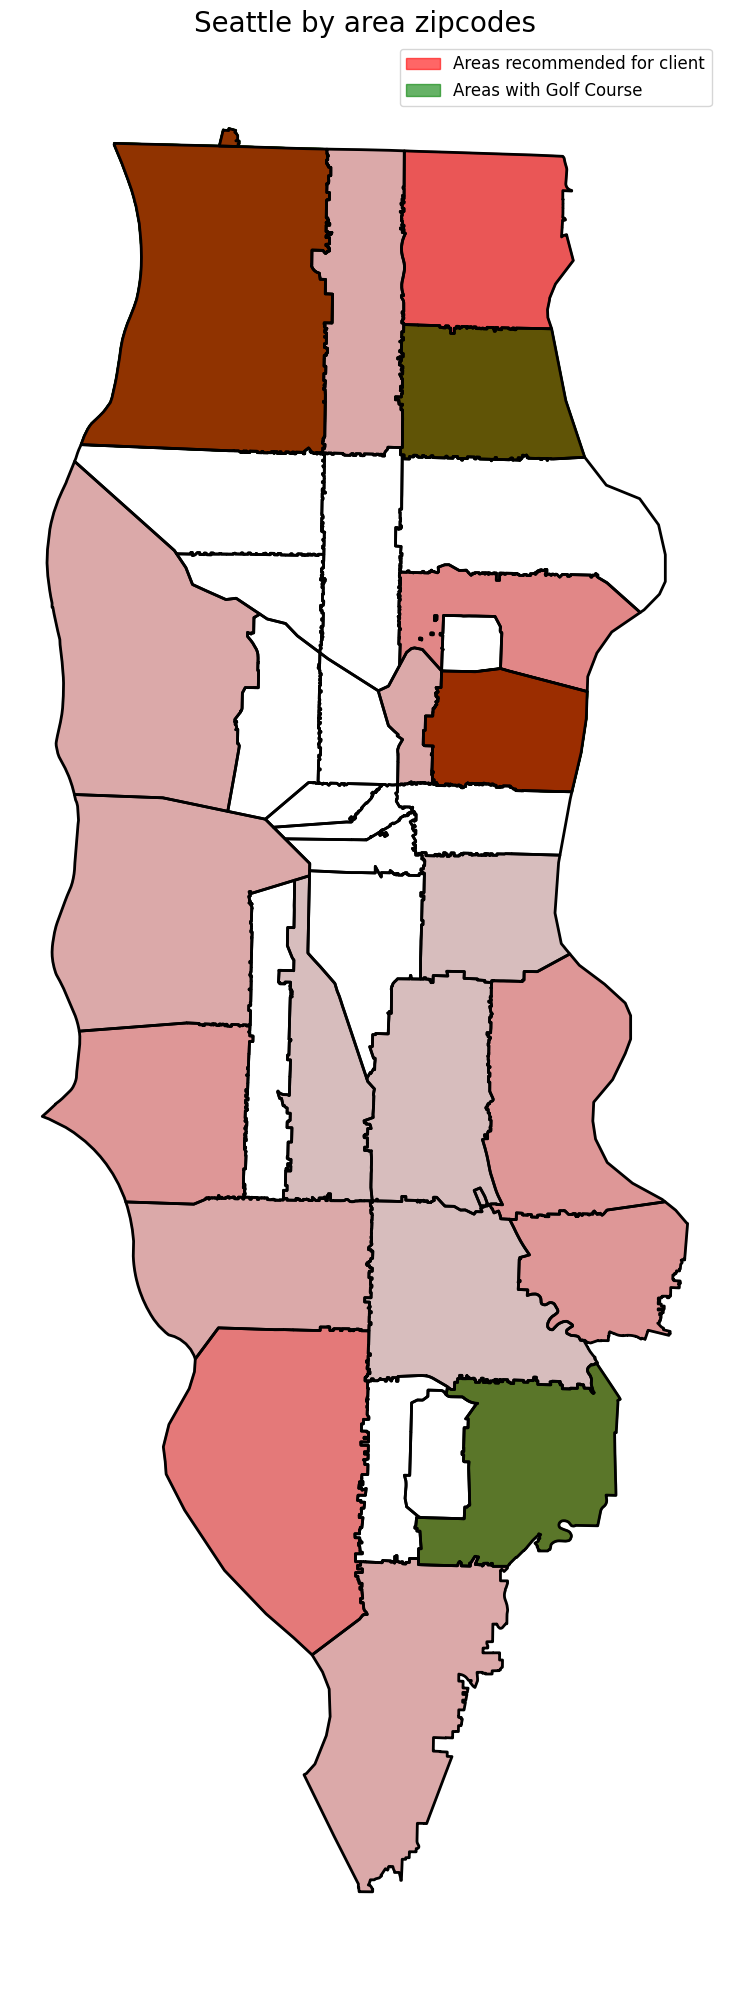

In [72]:
# 2+ bathroom condition mapped

df_lesser_houses['zipcode']= df_lesser_houses['zipcode'].astype(str)

mapstats_lesser = seattle.merge(df_lesser_houses, on = 'zipcode')

mapstats_lesser['seattle_highlight'] = mapstats_lesser['zipcode'].isin(seattle_zips)

target_zipcodes = [str(zipcode) for zipcode in df_lesser_houses['zipcode']]
golf_course_zips = [str(zipcode) for zipcode in golf_course_zips]


mapstats_lesser['houses_highlight'] = mapstats_lesser['zipcode'].isin(target_zipcodes)
mapstats_lesser['golf_highlight'] = mapstats_lesser['zipcode'].isin(golf_course_zips)


fig, ax = plt.subplots(1, figsize=(20, 20))

#all zipcodes 
mapstats_lesser.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.5)

#golf course zipcodes
golf_highlighted = mapstats_lesser[mapstats_lesser['golf_highlight']]
golf_highlighted.plot(ax=ax, color='green', edgecolor='darkgreen', linewidth=1.5,alpha=0.5)

# lesser house zipcodes
house_highlighted = mapstats_lesser[mapstats_lesser['houses_highlight']]
house_highlighted.plot(ax=ax, color='red', edgecolor='darkred', linewidth=1.5, alpha= 0.1)

#seattle
seattle.plot(ax=ax, color='none', edgecolor='black', linewidth=2)


house_patch = mpatches.Patch(color='red', label='Areas recommended for client', alpha=0.6)
golf_patch = mpatches.Patch(color='green', label='Areas with Golf Course', alpha=0.6)


plt.legend(handles=[house_patch, golf_patch], loc='upper right', fontsize = 12)

plt.title('Seattle by area zipcodes', fontsize= 20 )
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
#Zipcodes of recommended area
df = df_possible_houses[df_lesser_houses['zipcode'].isin(golf_course_zips)]
dfs = df[df['zipcode'].isin(seattle_zips)]
dfs['zipcode'].unique()

C:\Users\Dizzzy\AppData\Local\Temp\ipykernel_19336\3727772888.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df_possible_houses[df_lesser_houses['zipcode'].isin(golf_course_zips)]


array(['98177', '98112', '98188'], dtype=object)